In [11]:
# copied from `predictions.ipynb`

class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

blood_meta, muscle_meta = load_metadata()

def simulated_r2(metadata, times):
    r2s = []
    for i in range(times):
        repeat_length_random = metadata.modal_allele[:]
        random.shuffle(repeat_length_random)
        inter_r, _ = pearsonr(metadata.modal_allele, repeat_length_random)
        r2s.append(inter_r**2)
    r2s.sort()
    def check_value(r_squared):
        p_value = 1 - bisect.bisect_right(r2s, r_squared)/float(times)
        return p_value
    return check_value


In [12]:
r2_simulation_size = 10**6

In [13]:
import random
import bisect
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import scipy
import json
import os

In [14]:
muscle_r2_to_p = simulated_r2(muscle_meta, r2_simulation_size)

In [15]:
blood_r2_to_p = simulated_r2(blood_meta, r2_simulation_size)

In [16]:
import numpy as np
def present_result(name, tissue, real_allele, simulated_allele, r_squared, p_value, repeats, title = True):
    plt.figure(figsize=(30, 20))
    x = real_allele
    y = simulated_allele
    plt.scatter([i + np.random.normal(0, 5) for i in x], y, alpha=0.1, marker=",")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), linewidth=4, color="r")
    plt.xlabel("Measured allele length", fontsize=50)
    plt.ylabel("Predicted allele length", fontsize=50)
    if title:
        plt.title("{} predictions of MAL using {} dataset in {}. r² is {}, corresponding p-value {}".format(repeats, name, tissue, r_squared, p_value))
    print("Repeating the experiment {} times, In {}, {} r² is {}, which corresponds to p-value {}".format(repeats, name, tissue, r_squared, p_value))

In [17]:
import os
os.listdir("simulation_results")

['all_blood_1000_500_2',
 'all_muscle_995_500_2',
 'all_muscle_1003_500_2',
 'all_muscle_996_500_2',
 'nakamori_muscle_50_500_2',
 'all_blood_5010_500_2',
 'all_blood_996_500_2',
 'nakamori_muscle_100_500_5',
 'all_blood_1004_500_2',
 'nakamori_muscle_1',
 'nakamori_muscle_1_500_2',
 'all_blood_1_500_2',
 'nakamori_muscle_100',
 'batra_blood_10000_500_2',
 'all_muscle_5010_500_2',
 'all_muscle_1002_500_2',
 'all_blood_1001_500_2',
 'all_blood_997_500_2',
 'nakamori_muscle_10_500_3',
 'nakamori_muscle_10_500_2',
 'nakamori_muscle_10000_500_2',
 'all_blood_998_500_2',
 'all_muscle_1004_500_2',
 'all_blood_995_500_2',
 'all_muscle_997_500_2',
 'all_blood_999_500_2',
 'all_muscle_1001_500_2',
 'all_muscle_1000_500_2',
 'batra_muscle_10000_500_2',
 'TNNI1_blood_10000_500_2',
 'nakamori_muscle_2_500_2',
 'TNNI1_muscle_10000_500_2',
 'all_blood_1003_500_2',
 'all_muscle_998_500_2',
 'nakamori_muscle_10',
 'nakamori_muscle_10_500_5',
 'all_muscle_999_500_2',
 'all_blood_1002_500_2',
 'nakamori

In [18]:
import json

In [19]:
r2_to_p = {"muscle": muscle_r2_to_p, "blood": blood_r2_to_p}

In [20]:
def present_results_path(path, title = True):
    with open(path) as f:
        data = json.load(f)
        predicted_alleles, real_alleles = data["predicted_alleles"], data["real_alleles"]
        r, _ = pearsonr(real_alleles, predicted_alleles)
        r_square = r**2
        filename = path.split("/")[-1]
        name, tissue, simulation_repeat, probes, dimensions = filename.split("_")
        present_result(name, tissue, real_alleles, predicted_alleles, r_square, r2_to_p[tissue](r_square), simulation_repeat, title=title)

In [21]:
def aggregate_experiments(paths):
    prefix = "simulation_results"
    final_result = {"predicted_alleles" : [], "real_alleles": []}
    aggregate_size = 0
    for filename in paths:
        current_size = int(filename.split("_")[2])
        aggregate_size += current_size
        with open(os.path.join(prefix, filename)) as f:
            result = json.load(f)
            for key in result:
                final_result[key].extend(result[key])
    horrible_filepath = os.path.join(prefix, "_".join(["_".join(paths[0].split("_")[:2]), str(aggregate_size), "_".join(paths[0].split("_")[3:])]))
    print(horrible_filepath)
    with open(horrible_filepath, "w") as f:
        json.dump(final_result, f)

In [22]:
blood_paths = ["all_blood_1000_500_2", "all_blood_1002_500_2", "all_blood_1004_500_2", "all_blood_995_500_2", "all_blood_997_500_2", "all_blood_999_500_2"
, "all_blood_1001_500_2", "all_blood_1003_500_2", "all_blood_1_500_2", "all_blood_996_500_2", "all_blood_998_500_2"]
muscle_paths = ["all_muscle_1000_500_2", "all_muscle_1002_500_2", "all_muscle_1004_500_2", "all_muscle_996_500_2", "all_muscle_998_500_2",
"all_muscle_1001_500_2", "all_muscle_1003_500_2", "all_muscle_995_500_2", "all_muscle_997_500_2", "all_muscle_999_500_2"]

aggregate_experiments(blood_paths)
aggregate_experiments(muscle_paths)

simulation_results/all_blood_9996_500_2
simulation_results/all_muscle_9995_500_2


In [25]:
paths = ["simulation_results/nakamori_muscle_10000_500_2",
         "simulation_results/nakamori_blood_10000_500_2",
         "simulation_results/TNNI1_muscle_10000_500_2",
         "simulation_results/TNNI1_blood_10000_500_2",
         "simulation_results/batra_muscle_10000_500_2",
         "simulation_results/batra_blood_10000_500_2",
         "simulation_results/all_blood_9996_500_2",
         "simulation_results/all_muscle_9995_500_2"]

Repeating the experiment 10000 times, In nakamori, muscle r² is 0.18474147991234927, which corresponds to p-value 0.026186000000000043
Repeating the experiment 10000 times, In nakamori, blood r² is 0.019271960846860187, which corresponds to p-value 0.42479999999999996
Repeating the experiment 10000 times, In TNNI1, muscle r² is 0.2685814867578523, which corresponds to p-value 0.006344000000000016
Repeating the experiment 10000 times, In TNNI1, blood r² is 0.03580428540684154, which corresponds to p-value 0.275184
Repeating the experiment 10000 times, In batra, muscle r² is 0.10437985136735552, which corresponds to p-value 0.10011800000000004
Repeating the experiment 10000 times, In batra, blood r² is 0.05181171281813319, which corresponds to p-value 0.18809600000000004
Repeating the experiment 9996 times, In all, blood r² is 0.011542074932354306, which corresponds to p-value 0.5374749999999999
Repeating the experiment 9995 times, In all, muscle r² is 0.05614829931649612, which correspo

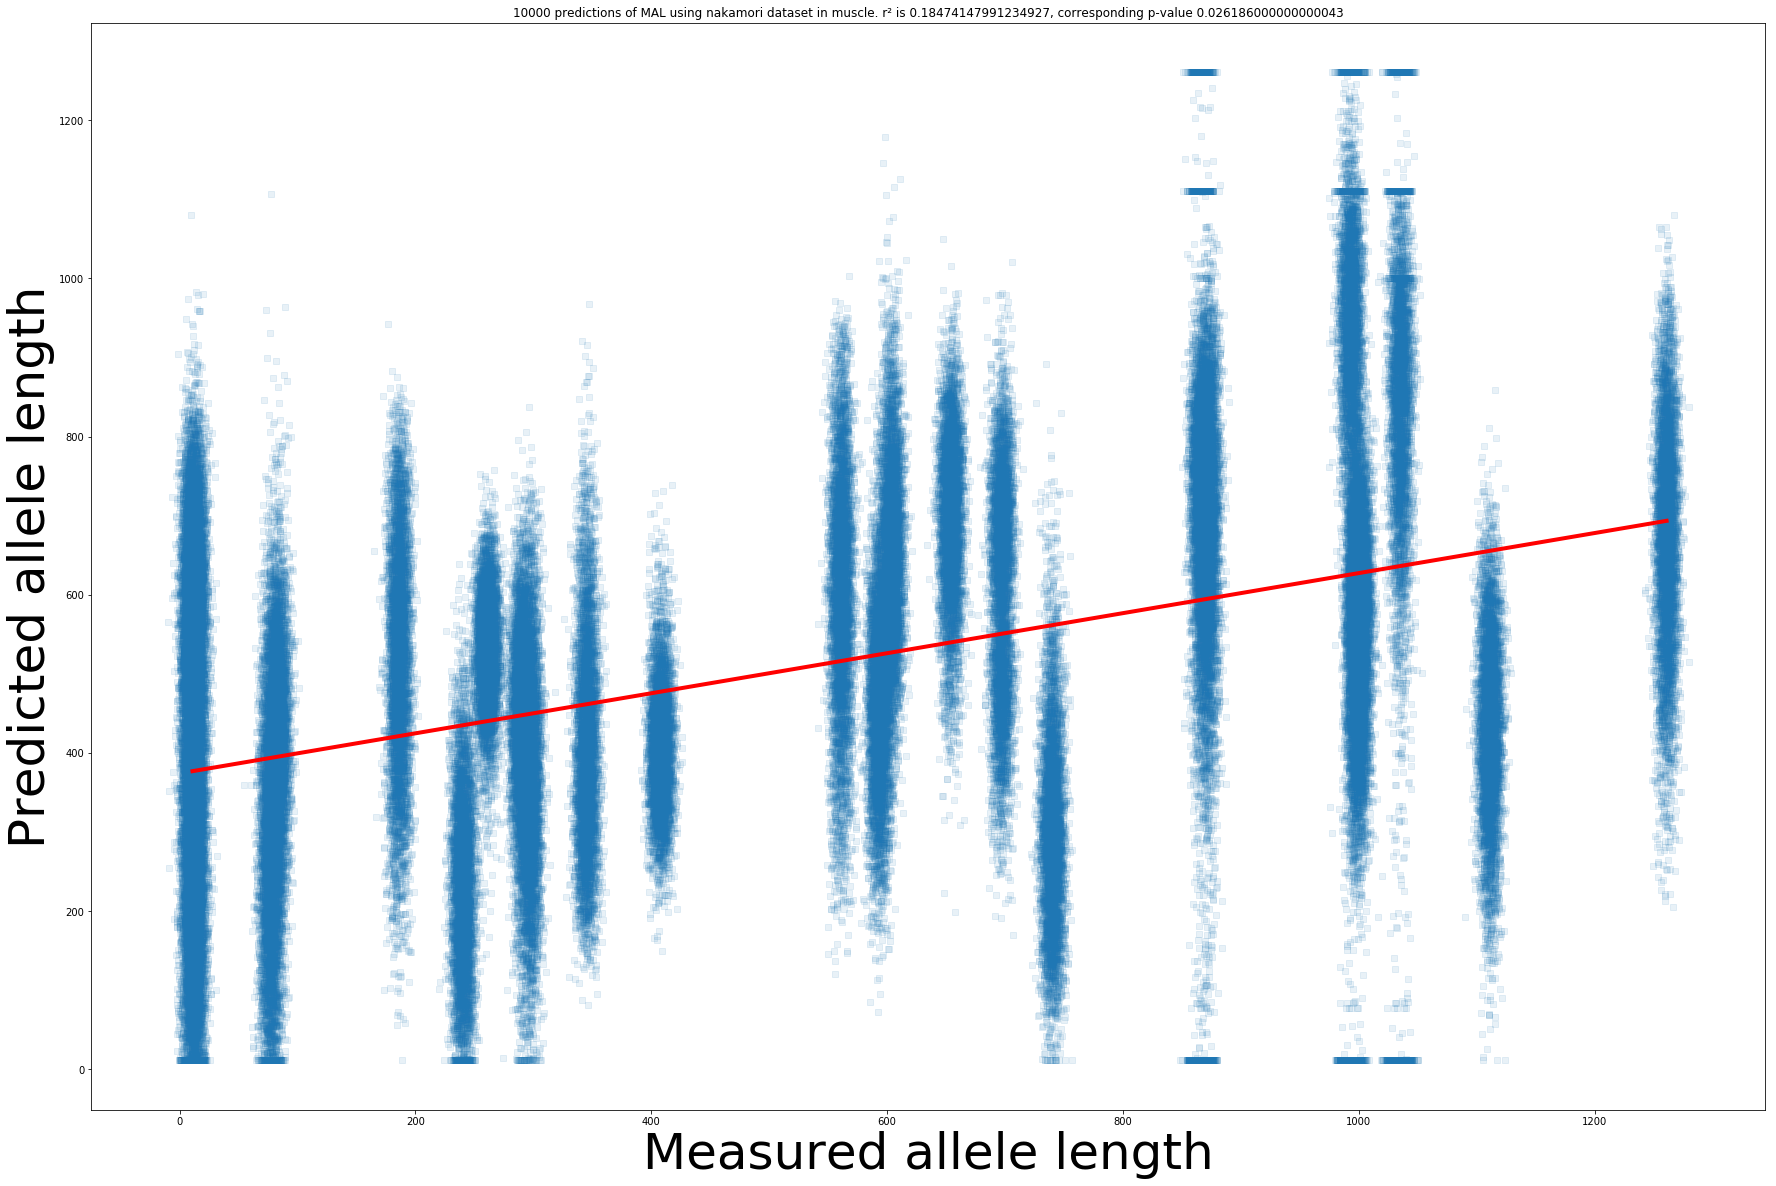

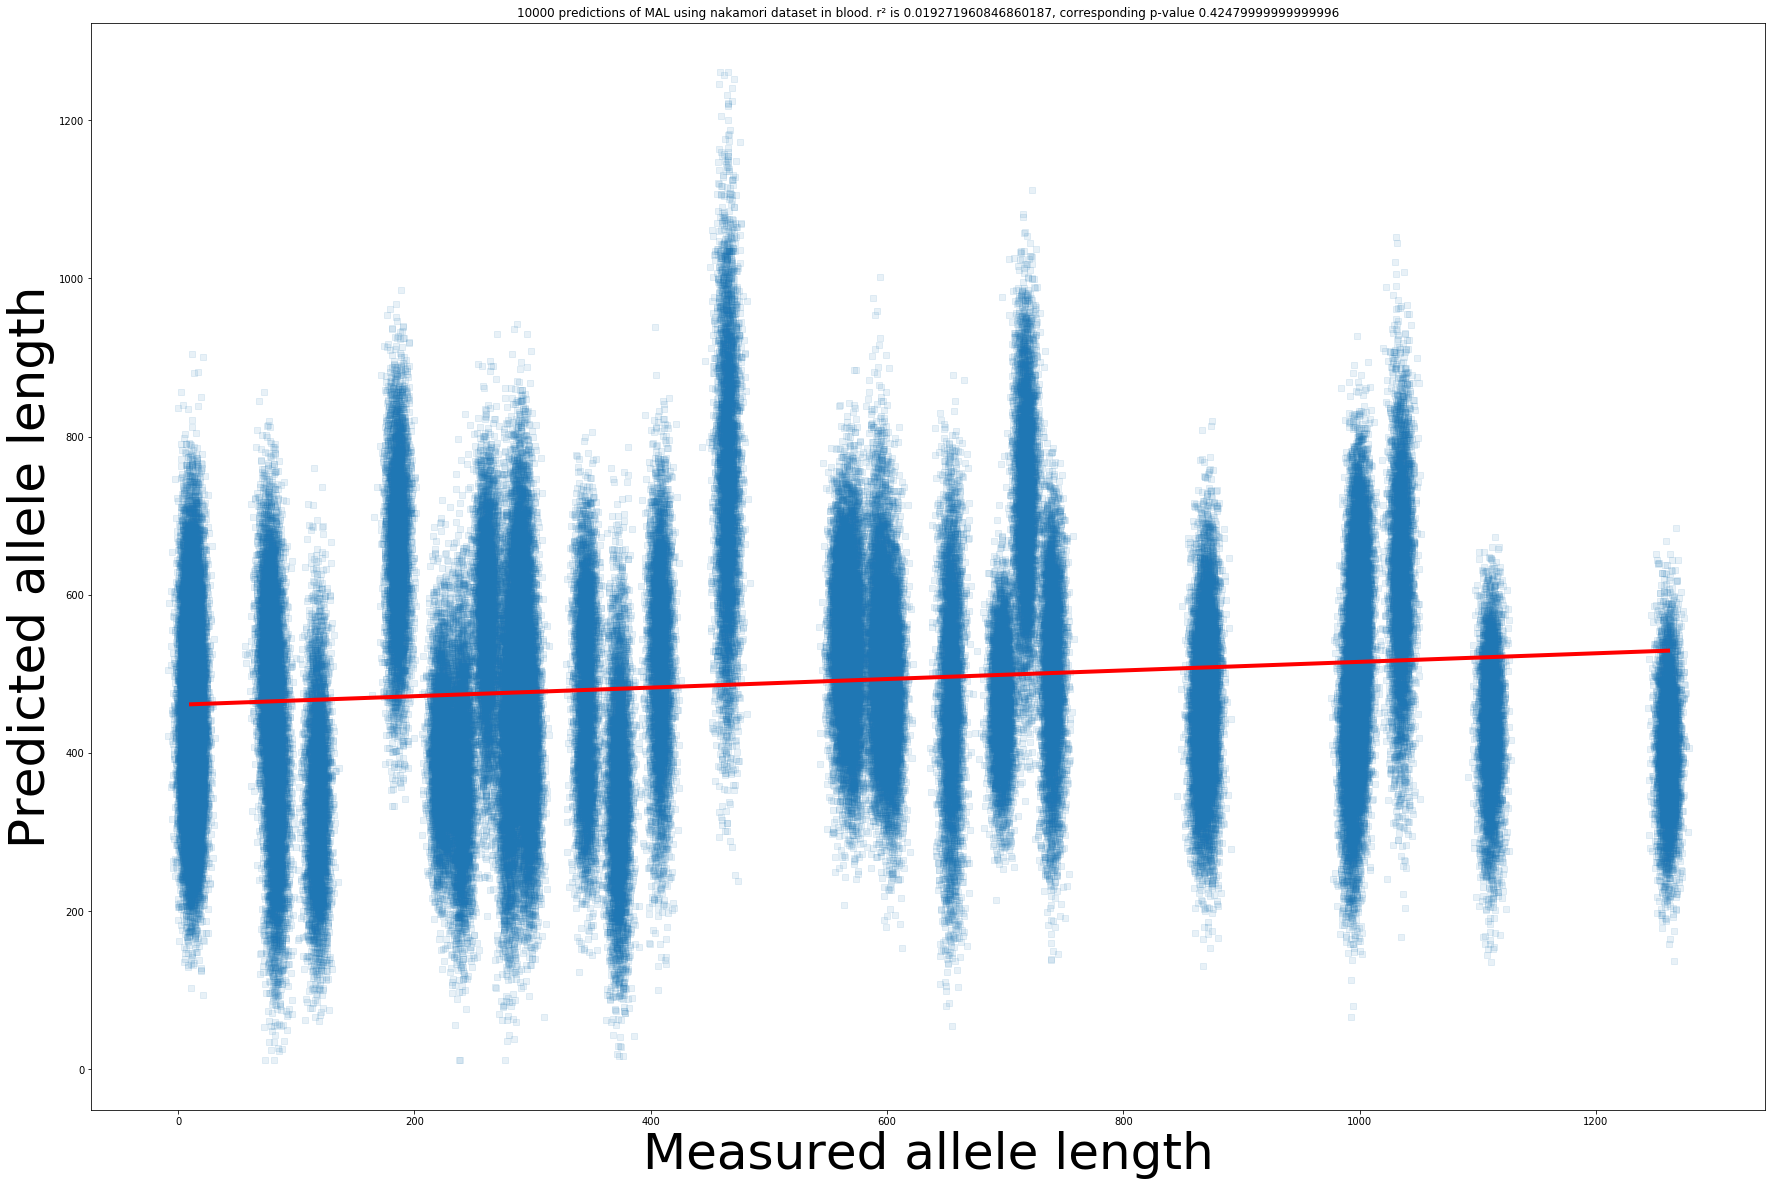

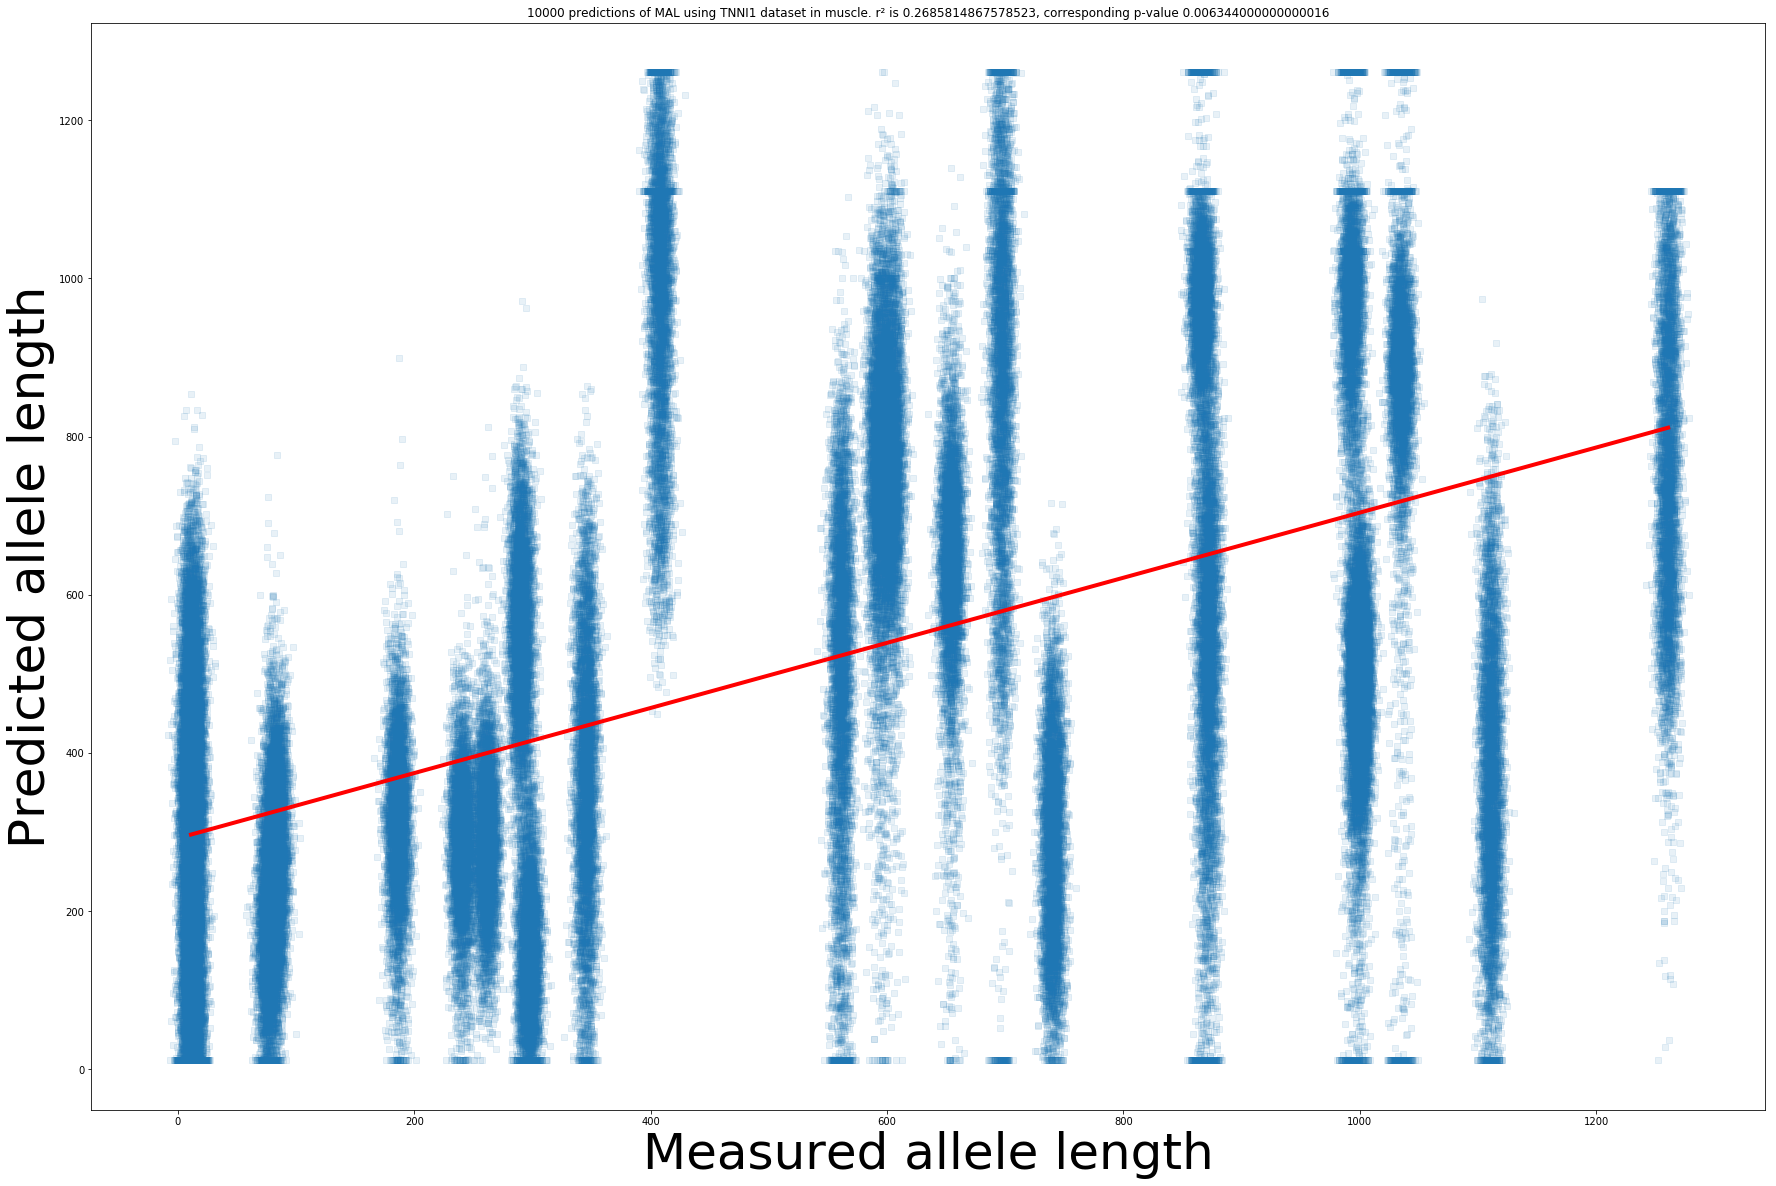

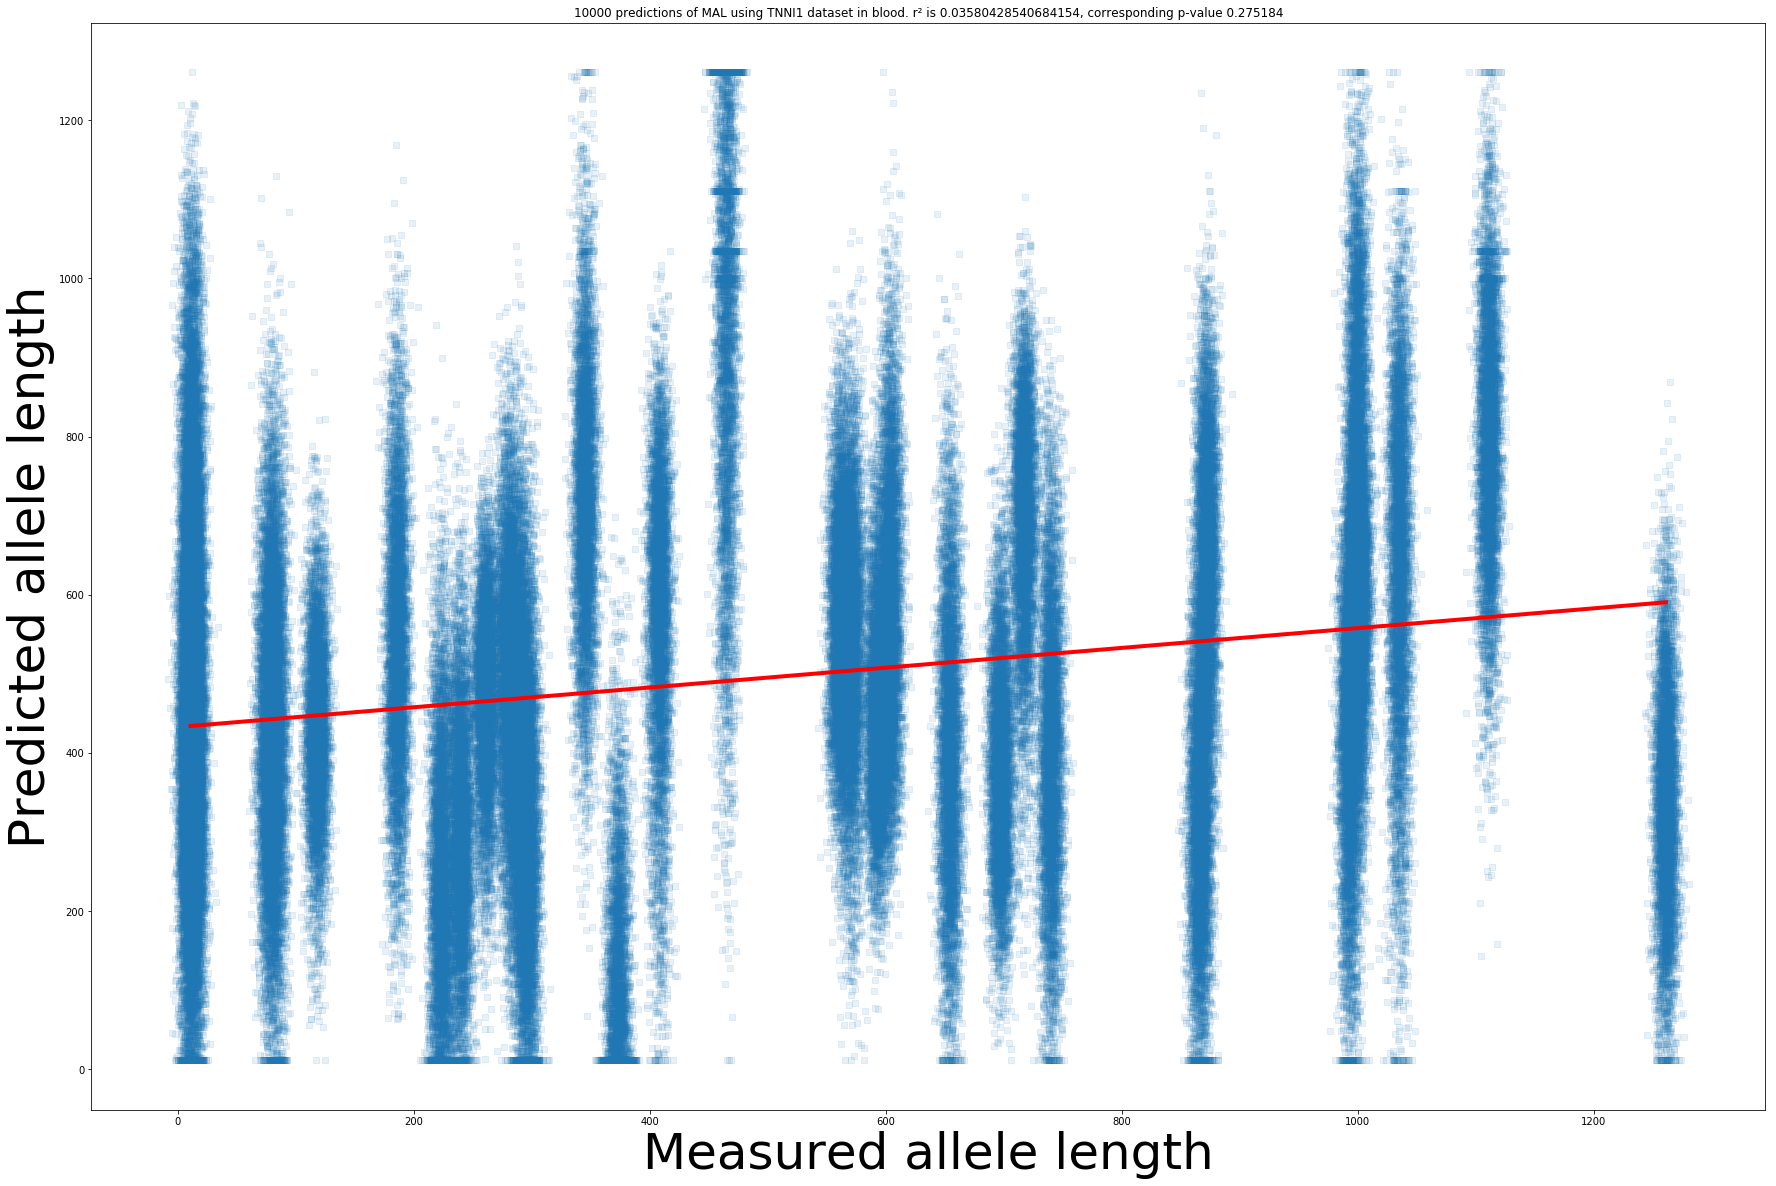

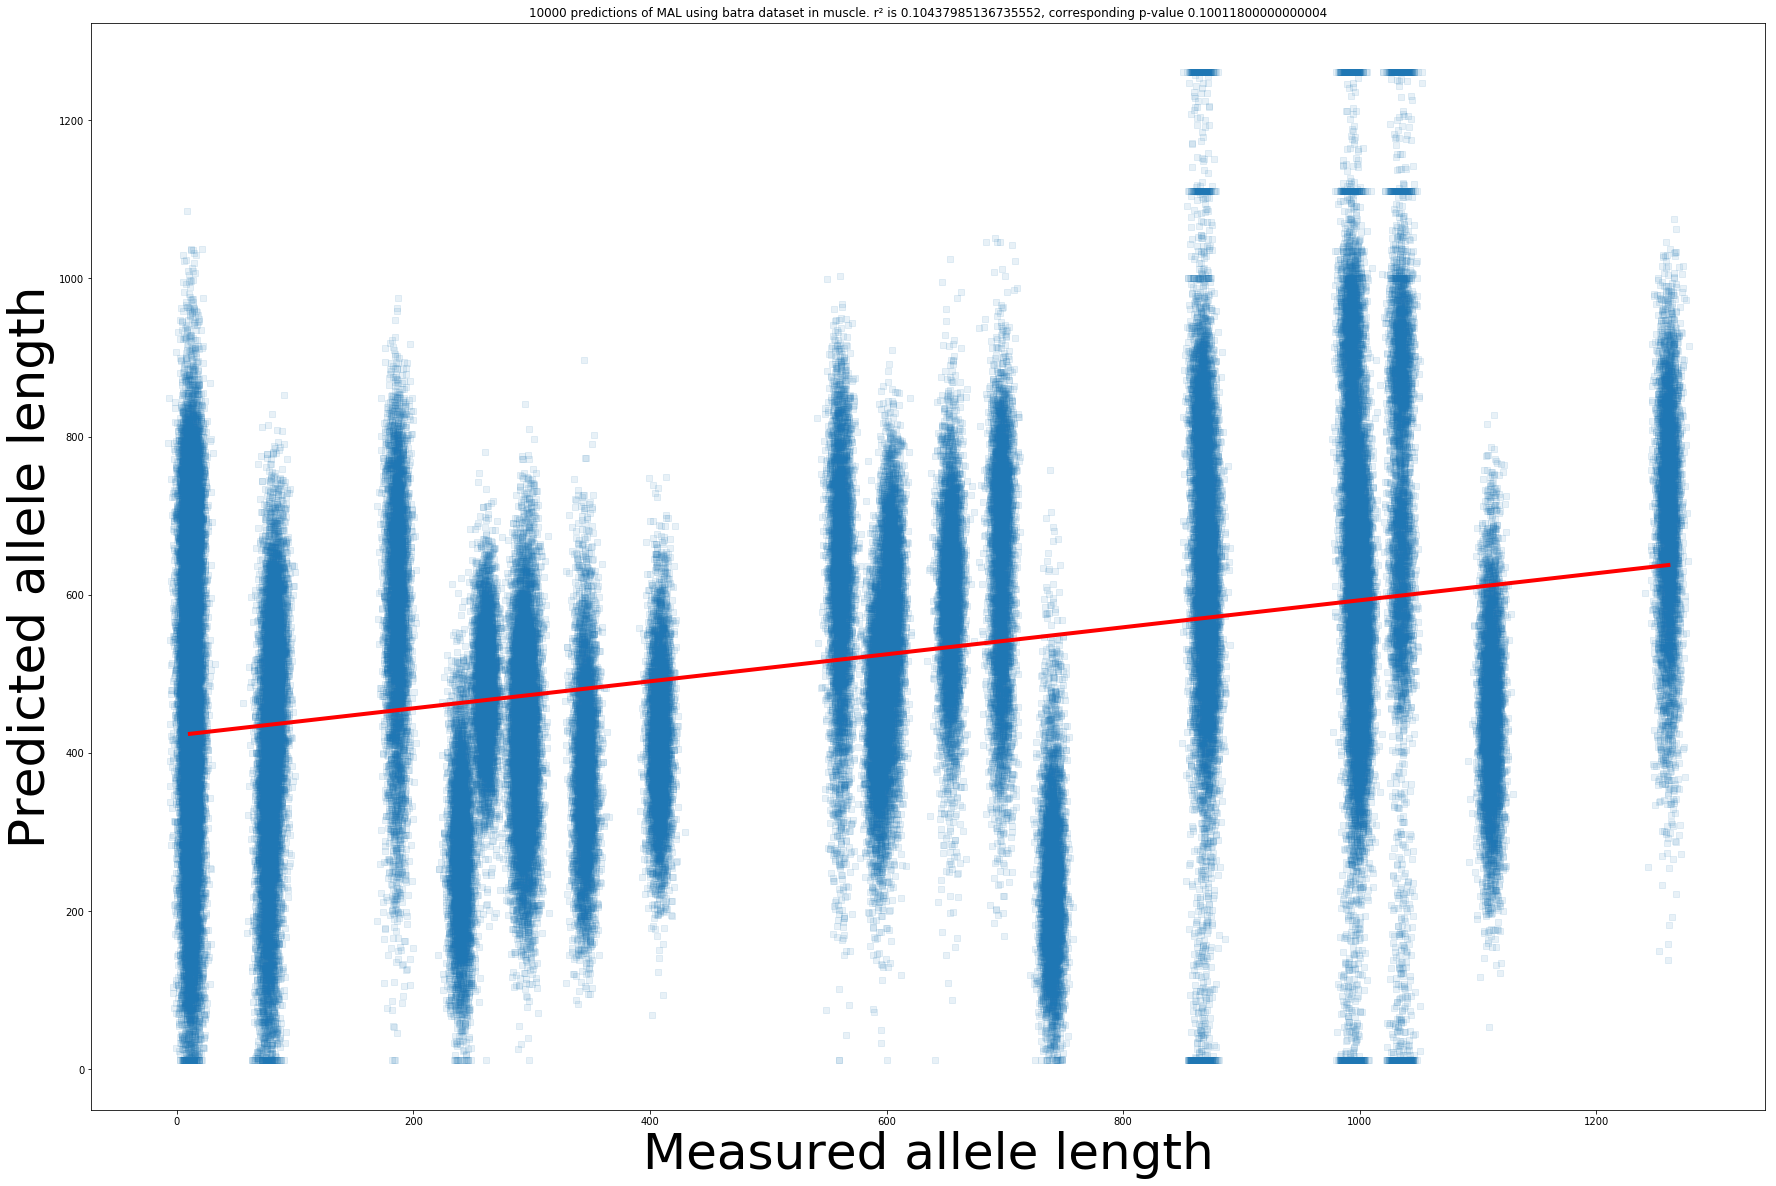

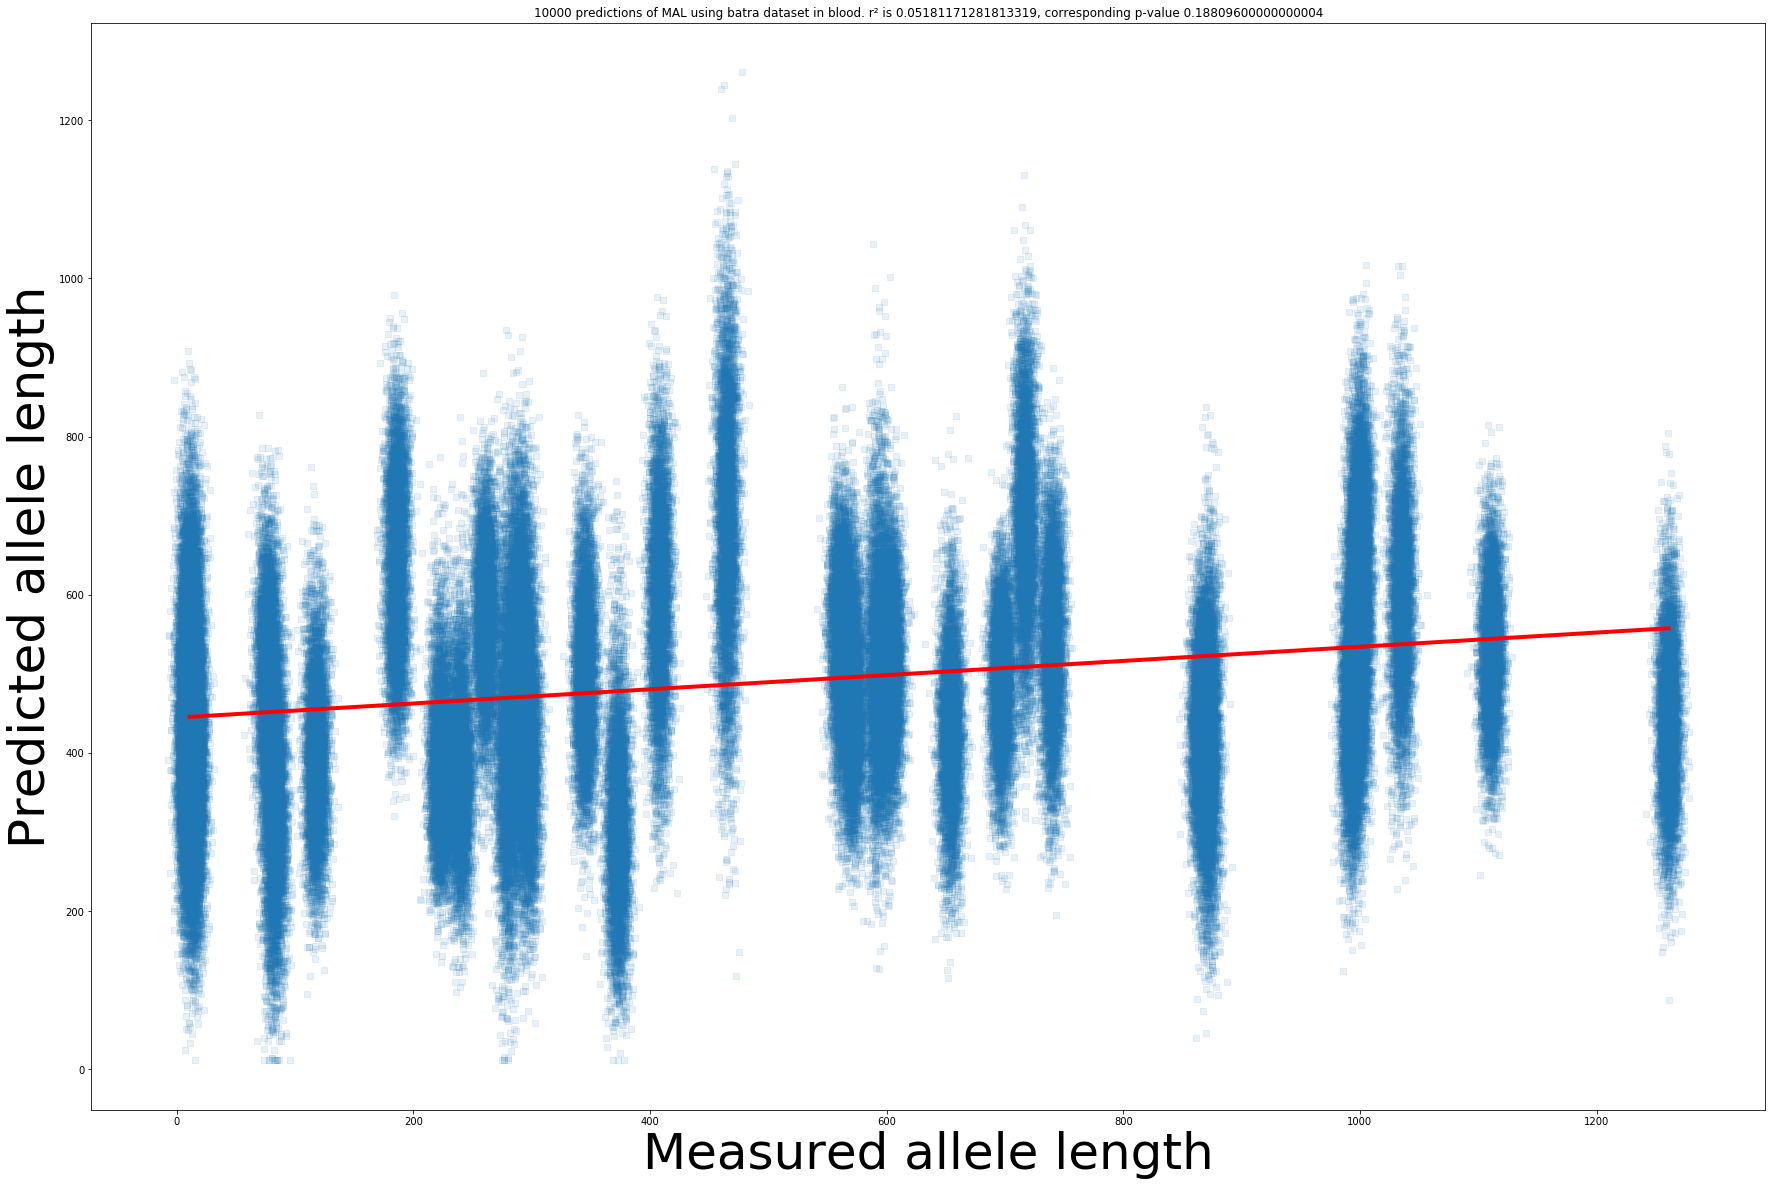

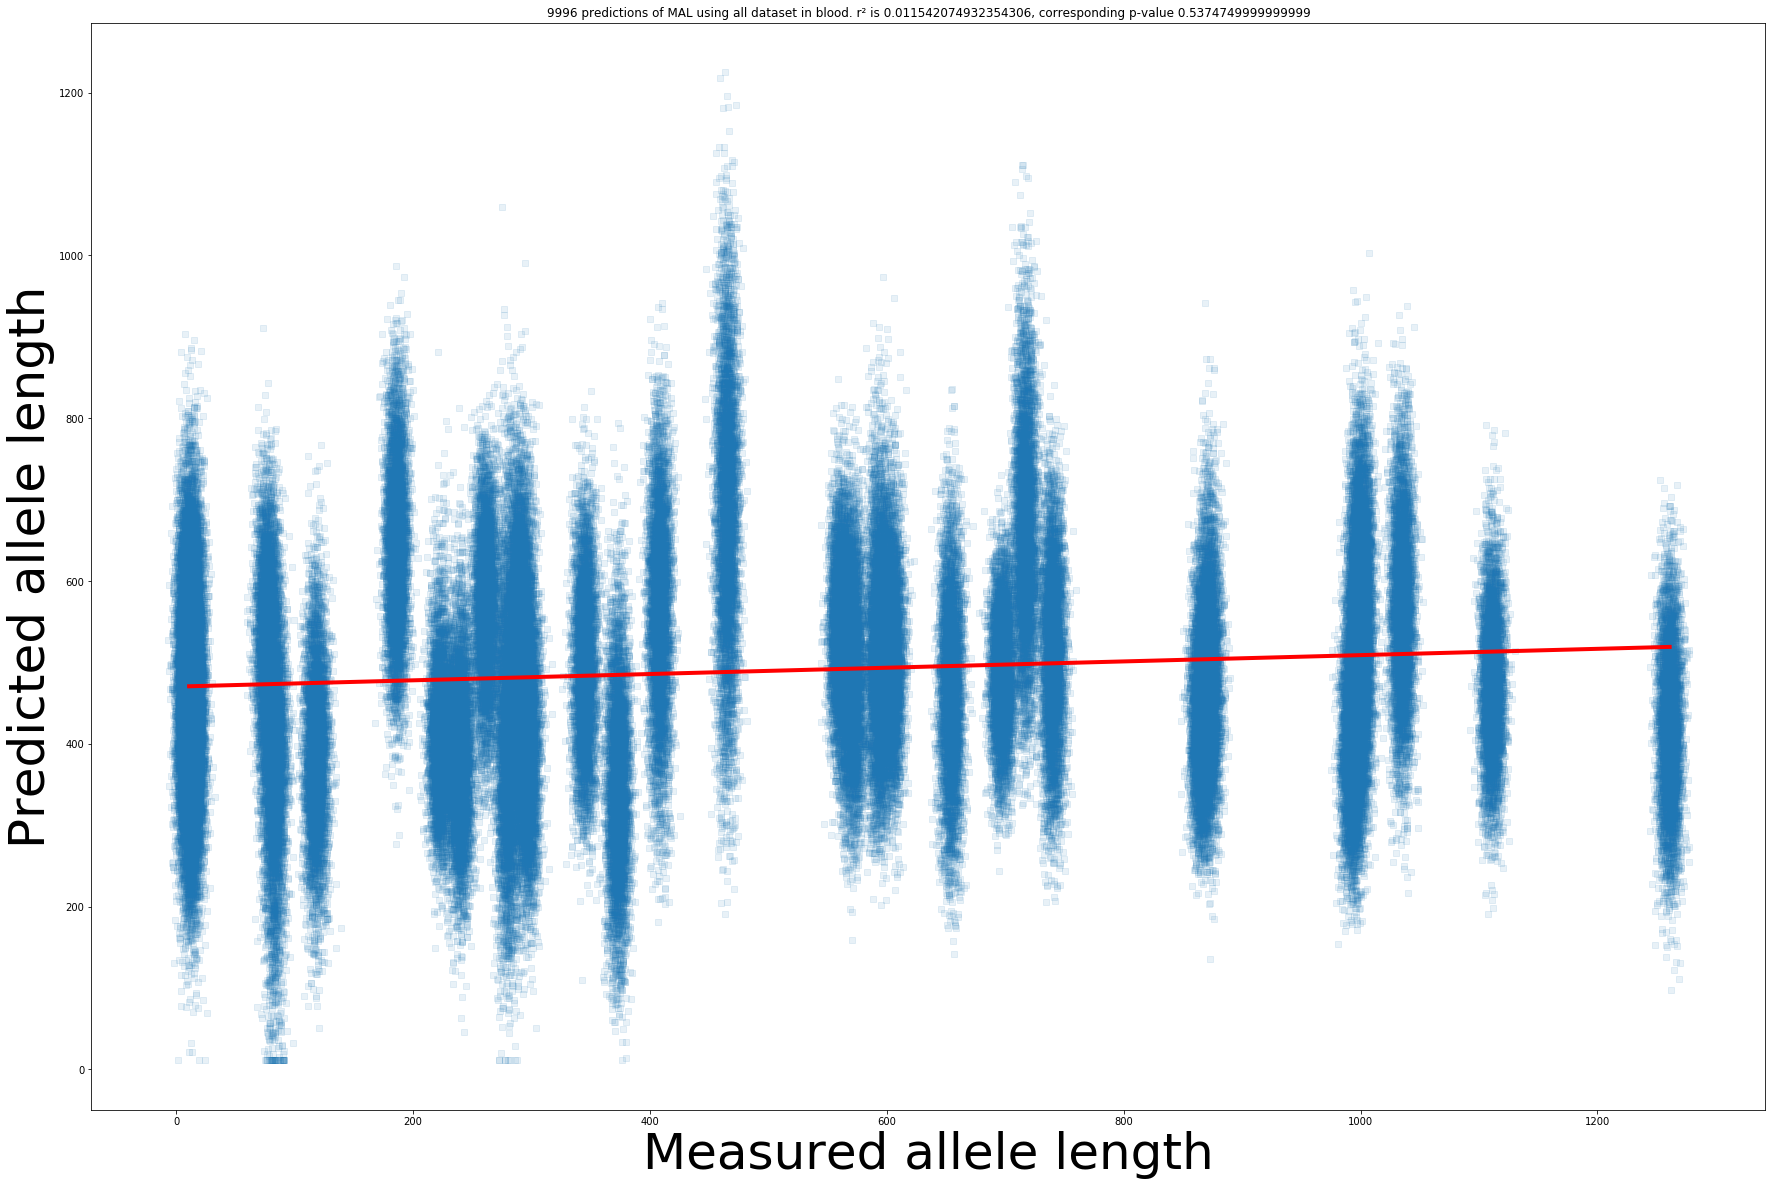

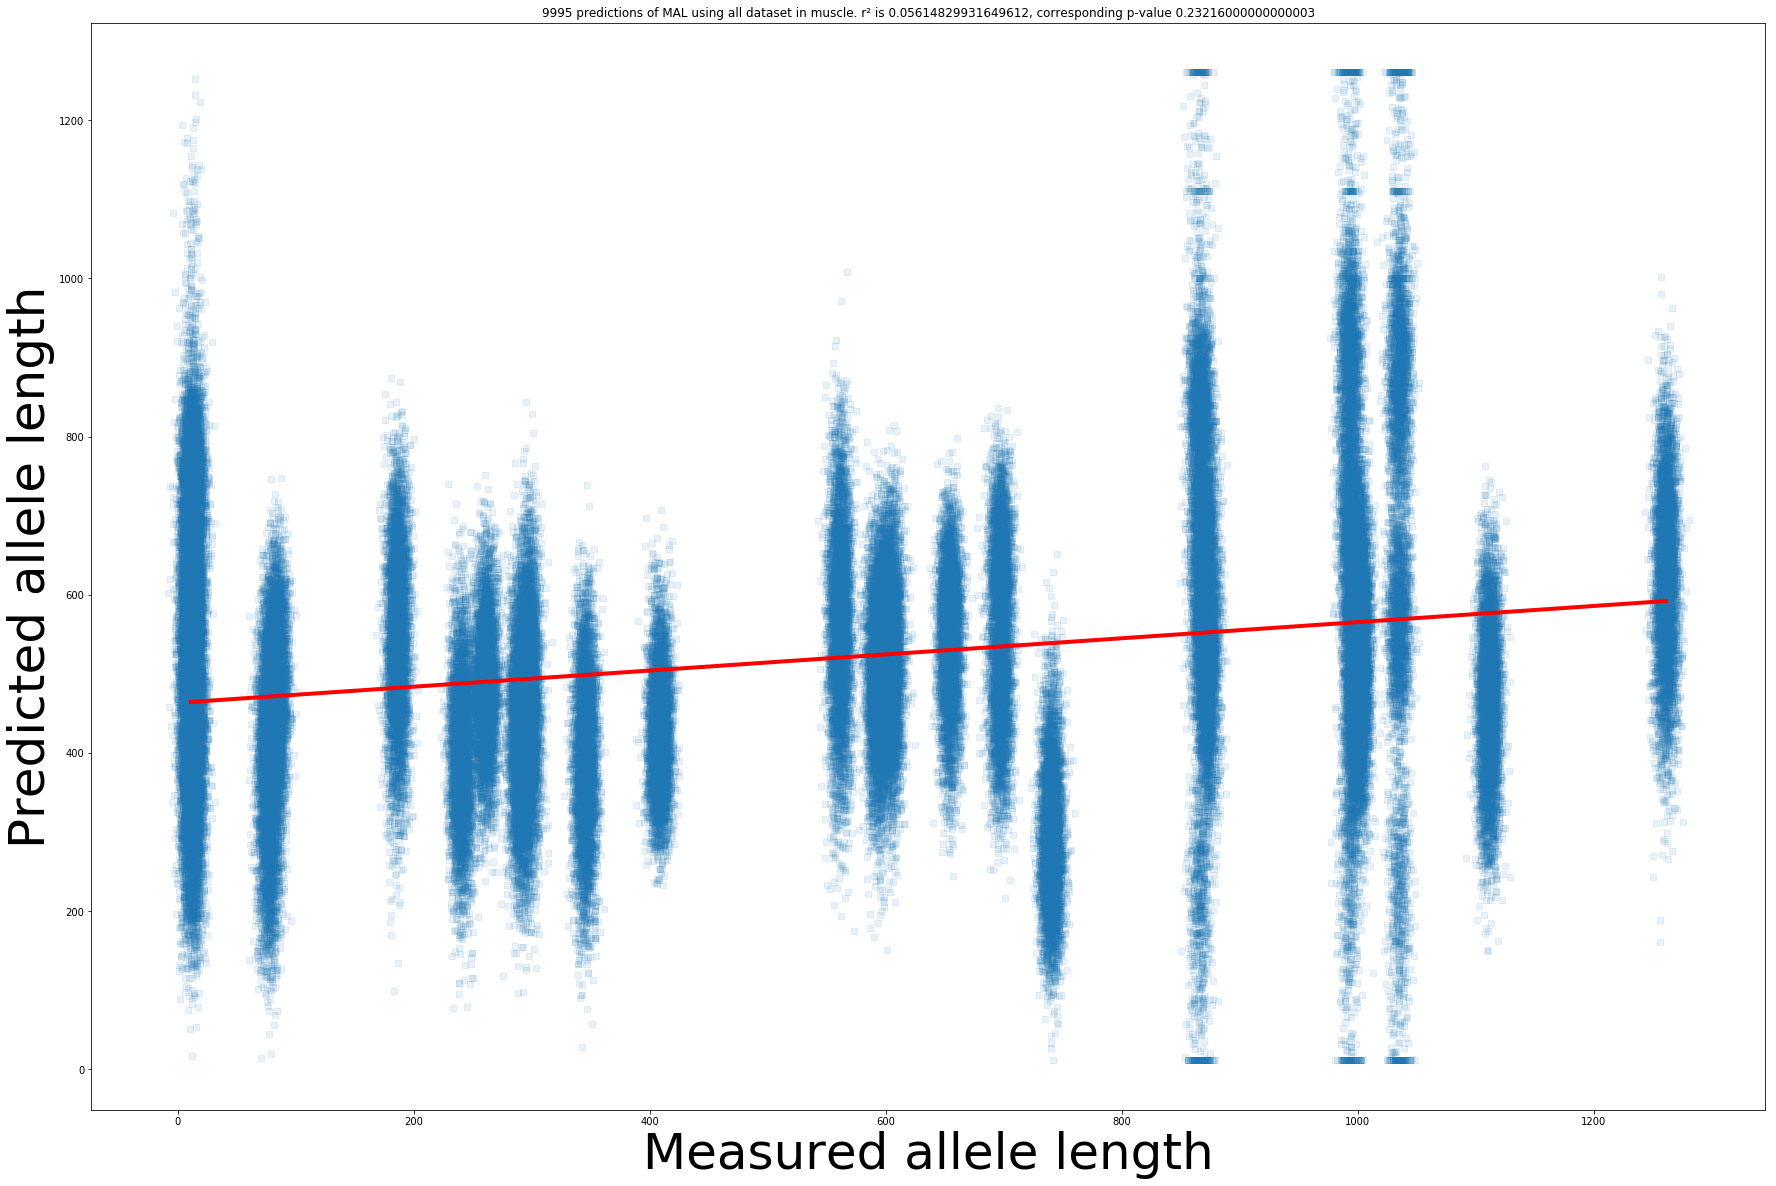

In [26]:
for path in paths:
    present_results_path(path)

In [27]:
font = {'family' : 'DejaVu Sans',
        'size'   : 25}

matplotlib.rc('font', **font)

Repeating the experiment 10000 times, In nakamori, muscle r² is 0.18474147991234927, which corresponds to p-value 0.026186000000000043


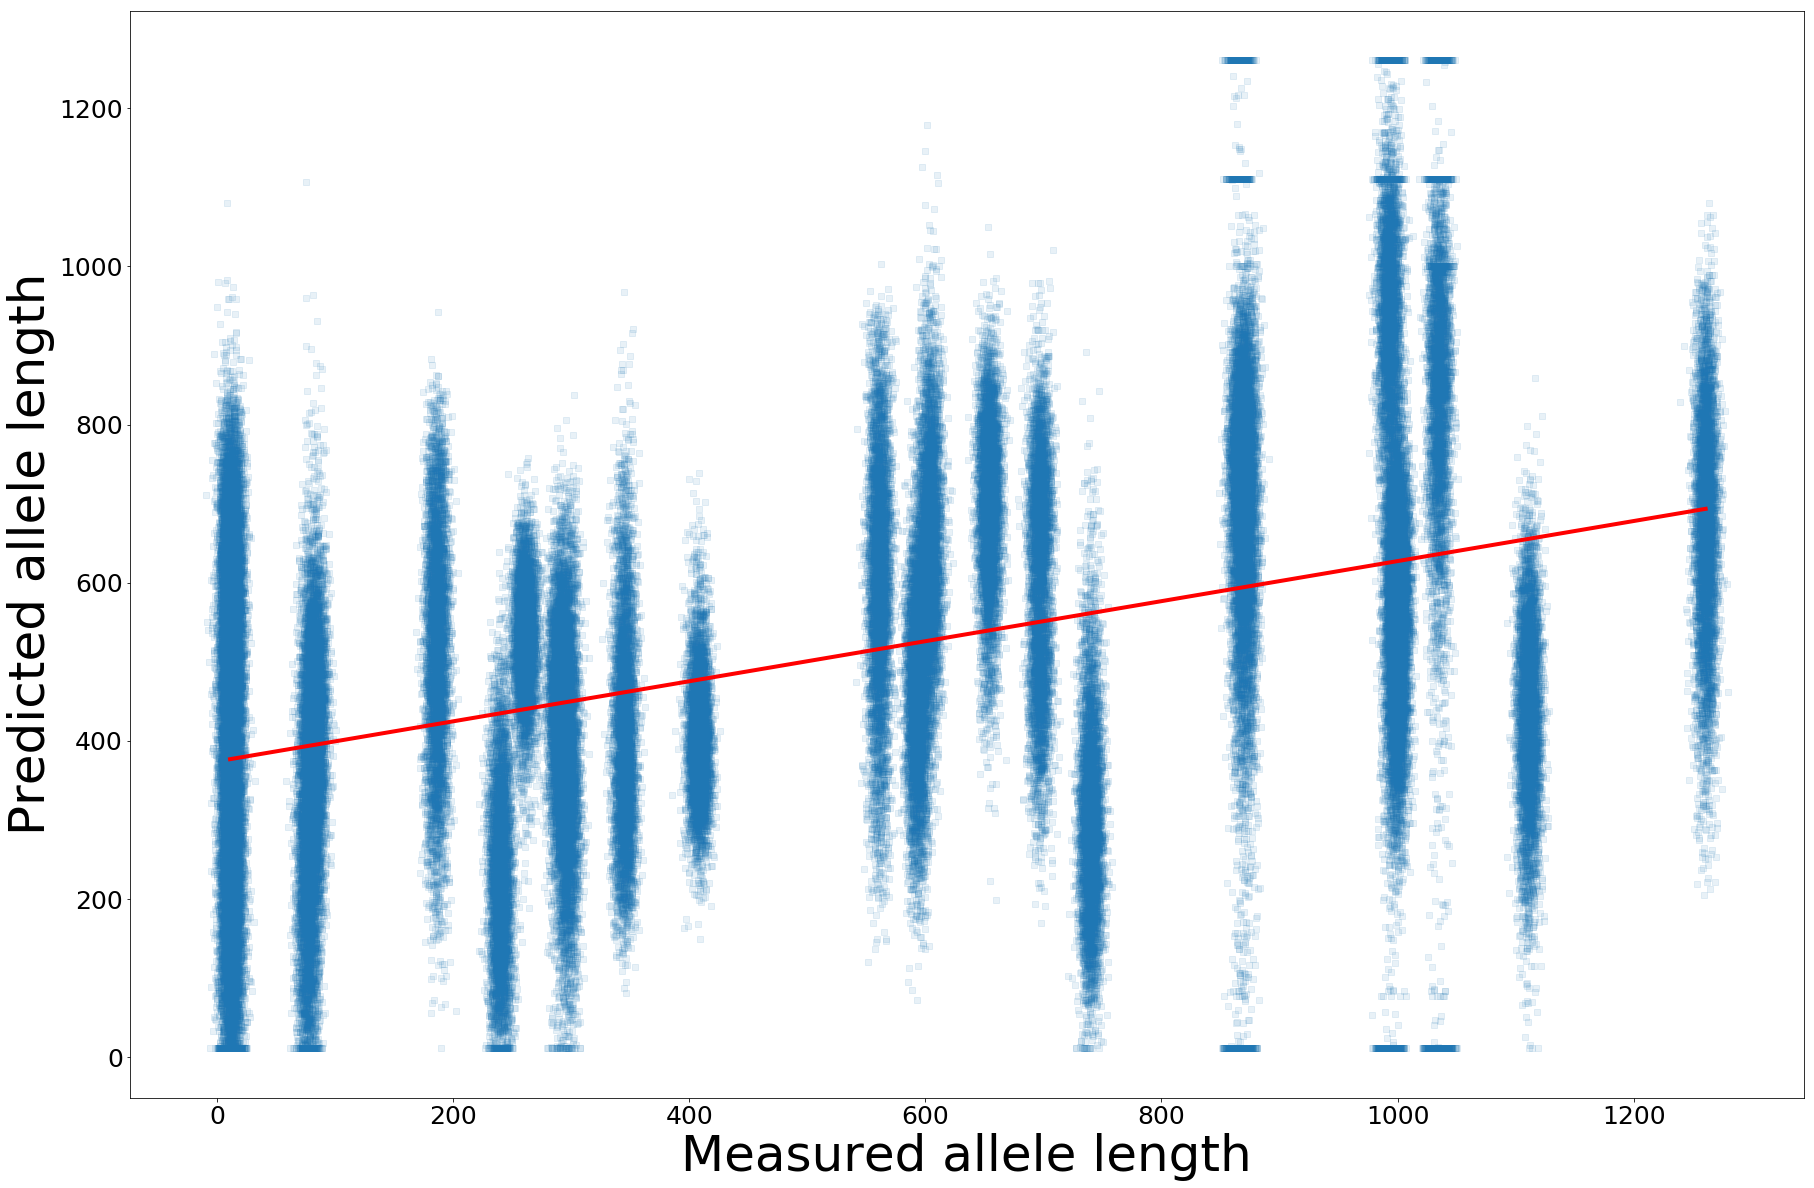

In [28]:
present_results_path("simulation_results/nakamori_muscle_10000_500_2", title=False)